##### Config

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='theano')

# Style
plt.style.use('default')
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
plt.rcParams['font.cursive'] = ['Liberation Sans']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.fallback_to_cm'] = True

In [4]:
del matplotlib; del plt; del warnings

##### Main

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.special import factorial
from utils import norm_cov
import george
from george.kernels import CosineKernel
from scipy.linalg import cho_factor

In [6]:
def compare(mu, Sigma, Sigma_norm_num, N=20):
    # Convergence metric
    Ez2 = np.mean(Sigma) / mu ** 2
    
    # Compute the normalized covariance analytically
    Sigma_norm_series = norm_cov(mu, Sigma, N=N)[0]
    
    # Mean relative difference, normalized to the variance
    error = np.mean(np.abs(Sigma_norm_series - Sigma_norm_num) / Sigma_norm_num[0])
    
    return error, Ez2

In [7]:
def get_Sigma(mu=0.6, std=0.1, offset=0.5, K=1000, M=100000):
    """
    Return the covariance matrix and the numerical estimate
    of the normalized covariance matrix
    
    """
    # Get the covariance
    t = np.linspace(0, 1, K)
    kernel = std ** 2 * (offset + CosineKernel(0))
    gp = george.GP(kernel)
    gp.compute(t)
    Sigma = gp.get_matrix(t)
    
    # Draw `M` samples, normalize them,
    # and compute the covariance
    x = mu + gp.sample(size=M)
    xnorm = x / np.mean(x, axis=1)[:, None]
    Sigma_norm_num = np.cov(xnorm.T)[0]
    
    return Sigma, Sigma_norm_num

In [8]:
nstd = 25
mu = 0.6
std = np.logspace(-2, 0, nstd)
error = np.empty(nstd)
Ez2 = np.empty(nstd)
for n in tqdm(range(nstd)):
    Sigma, Sigma_norm_num = get_Sigma(mu=mu, std=std[n])
    error[n], Ez2[n] = compare(mu, Sigma, Sigma_norm_num)

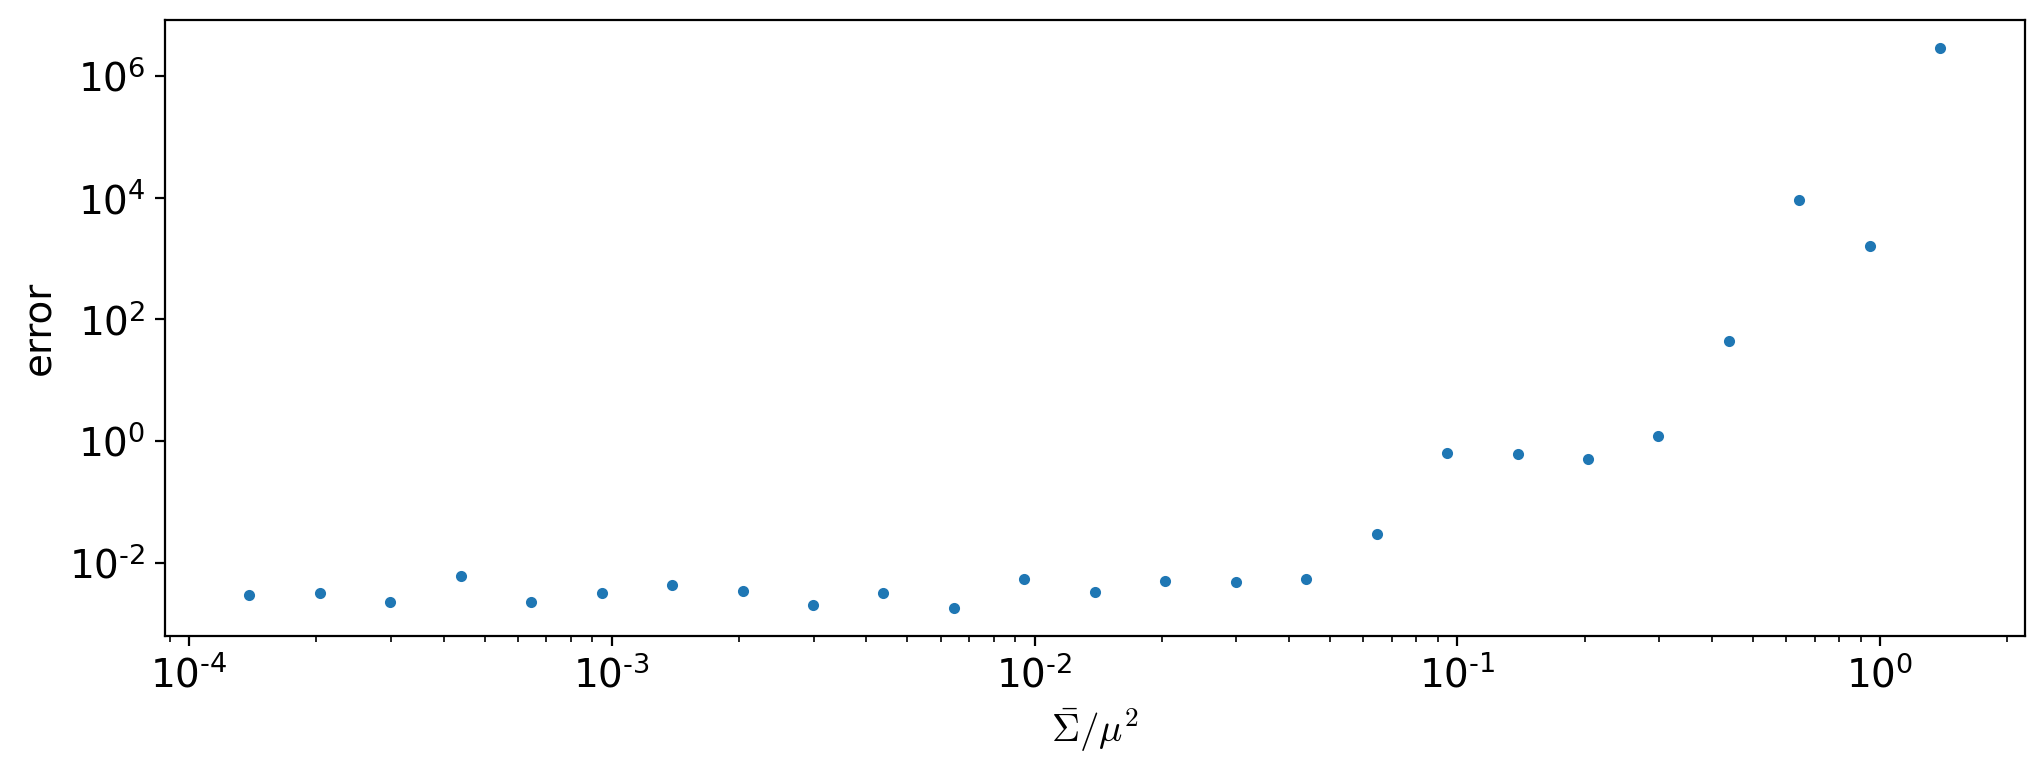

In [9]:
plt.plot(Ez2, error, ".")
plt.xscale("log")
plt.yscale("log");
plt.xlabel(r"$\bar{\Sigma} / \mu^2$")
plt.ylabel("error");